# ISPR Midterm 2 - Assignement 2
# Alessandro Trenta - 566072

Load and unzip data

In [2]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip /content/msrc_objcategimagedatabase_v1.zip

--2022-04-11 13:10:50--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.54.200.130, 2600:1402:2000:193::e59, 2600:1402:2000:1bb::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.54.200.130|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2022-04-11 13:10:51--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.54.200.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  7

Installing an older version of opencv as SIFT is no more available in newer releases.

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 2.0 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 55.6 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Import necessary libraries and modules and set the random state

In [4]:
import os
from scipy import misc
import imageio
import numpy as np
import glob
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

# Set the random state used
random_state = 100
np.random.seed(random_state)

Brief look at images from different thematic subsets

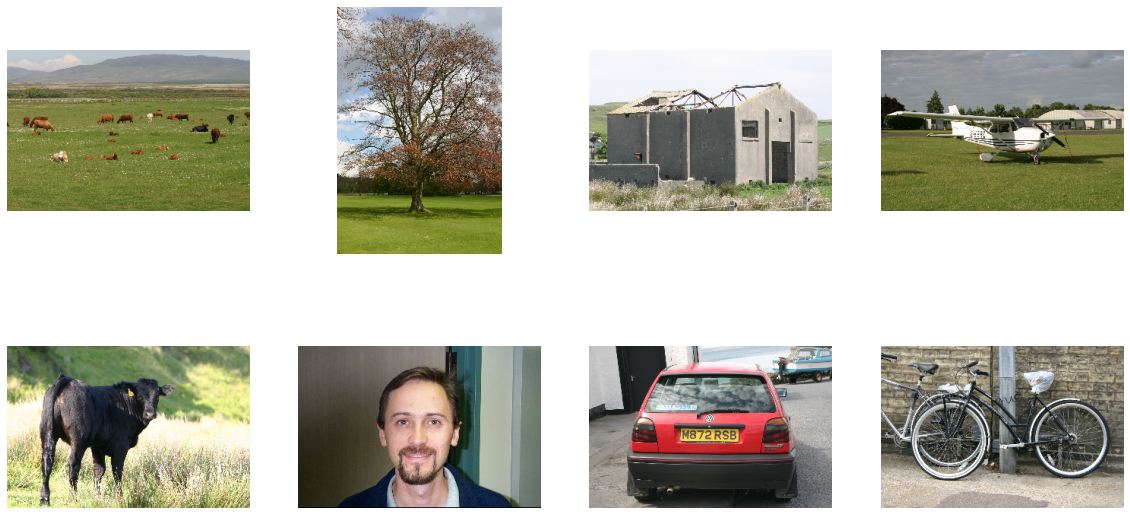

In [5]:
# Set path and select example images
path = '/content/MSRC_ObjCategImageDatabase_v1'
image1 = imageio.imread(os.path.join(path,'1_10_s.bmp'))
image2 = imageio.imread(os.path.join(path,'2_10_s.bmp'))
image3 = imageio.imread(os.path.join(path,'3_10_s.bmp'))
image4 = imageio.imread(os.path.join(path,'4_10_s.bmp'))
image5 = imageio.imread(os.path.join(path,'5_10_s.bmp'))
image6 = imageio.imread(os.path.join(path,'6_10_s.bmp'))
image7 = imageio.imread(os.path.join(path,'7_10_s.bmp'))
image8 = imageio.imread(os.path.join(path,'8_10_s.bmp'))

# Plot example images
F, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(image1)
ax[0,0].axis('off')
ax[0,1].imshow(image2)
ax[0,1].axis('off')
ax[0,2].imshow(image3)
ax[0,2].axis('off')
ax[0,3].imshow(image4)
ax[0,3].axis('off')
ax[1,0].imshow(image5)
ax[1,0].axis('off')
ax[1,1].imshow(image6)
ax[1,1].axis('off')
ax[1,2].imshow(image7)
ax[1,2].axis('off')
ax[1,3].imshow(image8)
ax[1,3].axis('off')

plt.show()

Define training and test indexes. We select one test image for each of the 8 thematics.

In [6]:
# Gen list of all indexes
indexes = np.arange(30*8)
# Choose 8 random integers in [0,29]
test_indexes = np.random.randint(low=0, high=30, size=8)
for i in range(8):
  test_indexes[i] = test_indexes[i] + 30*i
# Obtain train indexes
train_indexes = np.setdiff1d(indexes, test_indexes)
print('Train indexes:')
print(train_indexes)
print('Test indexes:')
print(test_indexes)

Train indexes:
[  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55
  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239]
Test indexes:
[  8  54  63  97 143 165 196 

Import the images and divide them into train and test. Train samples: 232, test samples: 8

In [7]:
# Import the images
filelist = sorted(glob.glob(os.path.join(path, '*s.bmp')))
images = np.array([np.array(imageio.imread(fname)) for fname in filelist], dtype=object)

# Generate the labels vector
label_gen = np.ones(240)
for i in range(8):
  label_gen[i*30:i*30+30] = i+1
tot_labels = np.array(label_gen, dtype='uint8')
labels = [1,2,3,4,5,6,7,8]

# Train test split of dataset
train_images = images[train_indexes]
test_images = images[test_indexes]
train_labels = tot_labels[train_indexes]
test_labels = tot_labels[test_indexes]

# Get dimensions
train_size = train_images.shape[0]
test_size = 8
print(f'Train size: {train_size}, test size: {test_size}')

Train size: 232, test size: 8


## SIFT extractor
In this part of the experiment we create the SIFT object and detect the SIFT descriptors and keypoints for each image.

In [8]:
# Create the SIFT object
sift = cv.xfeatures2d.SIFT_create()

SIFT descriptors detection on trining set

In [9]:
# Generate first SIFT descriptors
kp, des = sift.detectAndCompute(cv.cvtColor(train_images[0], cv.COLOR_RGB2GRAY), None)
train_kp = np.array(kp, dtype=object)
train_des = np.array(des)
train_data = []
train_data.append(des)

# Loop train images
for i in range(train_size):
  if i!=0:
    kp, des = sift.detectAndCompute(cv.cvtColor(train_images[i], cv.COLOR_RGB2GRAY), None)
    train_kp = np.concatenate((train_kp, np.array(kp)), axis=0)
    train_des = np.concatenate((train_des, np.array(des)), axis=0)
    train_data.append(des)

train_data = np.array(train_data, dtype=object)

print(train_kp.shape)
print(train_des.shape)
print(train_data.shape)

(106571,)
(106571, 128)
(232,)


In total we have 106571 keypoints in the training data.

Now we do the same for the test images.

In [10]:
# First descriptors
kp, des = sift.detectAndCompute(cv.cvtColor(test_images[0], cv.COLOR_RGB2GRAY), None)
test_kp = np.array(kp, dtype=object)
test_des = np.array(des)
test_data = []
test_data.append(des)

# Loop test data
for i in range(test_size):
  if i!=0:
    kp, des = sift.detectAndCompute(cv.cvtColor(test_images[i], cv.COLOR_RGB2GRAY), None)
    test_kp = np.concatenate((test_kp, np.array(kp)), axis=0)
    test_des = np.concatenate((test_des, np.array(des)), axis=0)
    test_data.append(des)
  
test_data = np.array(test_data, dtype=object)

print(test_kp.shape)
print(test_des.shape)
print(test_data.shape)

(3691,)
(3691, 128)
(8,)


In total we have 3691 keypoints in the test images.

## KMeans clustering
In shis section we cluster the SIFT keypoints and descriptors obtained in the training data. This way we generate a vocabulary of 500 visual words generated only using training data. The cluster centers are going to represent the 500 different visual words. Each descriptor will then be assigned to the nearest cluster center.

The n_init parameter is set to 10 (the number of initializations and tries) and to decrease the tolerance for convergence to 1e-6 hoping for better results.

In [11]:
# Set the number of visual words
n_clusters = 500
# Create and fit the kmeans object
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state, max_iter=200, tol=1e-6)
kmeans.fit(X=train_des)
# Obtain the cluster centers as the visual words
visual_words = kmeans.cluster_centers_

## Descriptor to word assignement
We assign each keypoint and SIFT descriptor the nearest cluster center using the K-Nearest-Neigbor function with k=1. This way we obtained the words for each image.

In [12]:
# Create and fit the KNN object with k=1
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X=visual_words, y=np.arange(start=0, stop=500))

KNeighborsClassifier(n_neighbors=1)

## Bag of visual words generation
The following function takes as input the image descriptors for each image and generates the document-visual words matrix for the bag of visual words approach.

The function takes as input:


*   data: array of arrays containing the image descriptors
*   n_words: the number of words in the vocabulary
*   kNN: the k-nearest-neighbor classifier object

and outputs the document-word matrix



In [13]:
# Function for the document-word matrix generation
def generate_matrix(data, n_words, kNN):
  # Generate the empty matrix
  data_size = data.shape[0]
  dict_matrix =np.zeros((data_size, n_words), dtype='uint8')

  # Loop images descriptors
  for i in range(data_size):
    # Get image descriptors
    image_des = data[i]
    # Obtain the words from the descriptors and the vocabulary using knn
    image_words = kNN.predict(image_des)
    # Loop the words
    for j in range(image_words.shape[0]):
      # Update the matrix
      dict_matrix[i, image_words[j]] = dict_matrix[i, image_words[j]] + 1

  return dict_matrix

Obtain the bags of visual words for the train and test data

In [14]:
train_bovw = generate_matrix(train_data, 500, kNN)
test_bovw = generate_matrix(test_data, 500, kNN)

## Latent Dirichlet Analysis
Here we generate the LDA model used for the topics analysis.

The number of topics should be in my opinion in the order of 10-30, so that for each topic there are approximately from 20 to 50 words which is a reasonable number. Having also much more topics would not make sense as topics should be big containers for words: having around 100 topics with 500 total words is not really useful. I choose 10 topics as this value is also similar the original 9 ground truth classes of the semantic segmentation of the images in this dataset.

I tried two different LDA implementations:

*   The first one is provided by the scikit-learn package: this has fixed α and β parameters
*   The second one is provided by the gensim package: this one allows to train the α and β parameters as well



### Scikit implementation
The scikit implementation of the lda model takes as input:
*   The number of topics: 10
*   The value for α: an higher value means that words have higher probabilities for each topic. A low value makes the topic-word distribution more spiked. I chose to go low with a value of 0.0005
*   The value for β: same as α but this modifies the behavior of the document-topic distribution in the same way. I chose a value of 0.001.
*   The maximum number of iteration for convergence: 1000
*   The batch size: 64 which is around 25% of the dataset. Going lower didn't improve significatively the performance.

In [29]:
# Set the number of topics
n_topics = 10
# Set the alpha and beta parameters for the Latent Dirichlet Analysis
alpha = 0.0005
beta = 0.001
# Set other parameters
max_iter = 1000
batch_size = 64

# Generate and fit the LDA object
lda = LatentDirichletAllocation(n_components=n_topics, doc_topic_prior=alpha, topic_word_prior=beta, random_state=random_state, max_iter=max_iter, batch_size=batch_size)
lda.fit(train_bovw)


LatentDirichletAllocation(batch_size=64, doc_topic_prior=0.0005, max_iter=1000,
                          random_state=100, topic_word_prior=0.001)

This utility function simply converts the bag of visual words into the correct format for the gensim lda model.

In [30]:
def generate_gensim_corpus(bovw, n_words):
  n_data = bovw.shape[0]
  # Create corpus
  corpus = []
  for i in range(n_data):
    # For each image generate the corpora
    image_corpora = []
    for j in range(n_words):
      # Format is list of lists of pairs (word_id, count)
      image_corpora.append((j, bovw[i,j]))
    corpus.append(image_corpora)
  return corpus

train_corpus = generate_gensim_corpus(train_bovw, 500)
test_corpus = generate_gensim_corpus(test_bovw, 500)


In [31]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Gensim implementation
The gensim implementation takes as input:
*   The number of topics: 10
*   The number of passes: the number of total iteration of the EM algorithm set to 20.
*   The chunksize: the batch size as before of 64.
*   The maximum number of iterations for inferring the document-topic distribution from one corpus: I preferred to go high and safe with 1000.
*   Remember that the parameters α and β are self learned by the algorithm with the "auto" flag


In [32]:
from gensim.utils import chunkize
from gensim.models.ldamodel import LdaModel
# Set the number of topics
n_topics = 10
passes = 200
chunksize = 64
iterations = 1000
lda_gen = LdaModel(corpus=train_corpus, num_topics=n_topics, alpha='auto', eta='auto', random_state=random_state, iterations=iterations, passes=passes, update_every=0, chunksize=chunksize, per_word_topics=True)

2022-04-11 14:32:39,594 : WARNING : no word id mapping provided; initializing from corpus, assuming identity
2022-04-11 14:32:39,612 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2022-04-11 14:32:39,614 : INFO : using serial LDA version on this node
2022-04-11 14:32:39,617 : INFO : running batch LDA training, 10 topics, 200 passes over the supplied corpus of 232 documents, updating model once every 232 documents, evaluating perplexity every 232 documents, iterating 1000x with a convergence threshold of 0.001000
2022-04-11 14:32:39,619 : INFO : PROGRESS: pass 0, at document #64/232
2022-04-11 14:32:40,571 : INFO : optimized alpha [0.05501321, 0.0488876, 0.102360755, 0.041361462, 0.055168156, 0.055989154, 0.058785815, 0.053237654, 0.10471624, 0.04746242]
2022-04-11 14:32:40,573 : INFO : PROGRESS: pass 0, at document #128/232
2022-04-11 14:32:41,399 : INFO : optimized alpha [0.039165154, 0.053671923, 0.048188236, 0.031945784, 0.052597087,

Here we set the colors for the topics. I tried to take the colors randomly hoping to get good contrast between them (which didn't work great). Alternatively on http://alumni.media.mit.edu/~wad/color/palette.html we can found a really useful palette of very distinguishable colors. I choose to use this instead.

In [33]:
colors = []
#for i in range(n_topics):
#  color = np.random.choice(range(256), size=3)
#  colors.append(tuple(color*1.))

colors = [(0., 0., 0.), (173., 35., 35.), (42., 75., 215.), (29., 105., 20.), (129., 74., 25.), (129., 38., 192.), (255., 255., 255.), (157., 175., 255.),
          (41., 208., 208.), (255., 146., 51.), (255., 238., 51.), (233., 222., 187.), (255., 205., 243.), (87., 87., 87.), (160., 160., 160.), (129., 197., 122.)]


## Test visual patches visualization
In this next section we consider the test images and their keypoints. For each descriptor we find the word (the cluster center) nearest to it and we obtain the corresponding topic using the trained lda model. We then assign the corresponding color to the keypoint and we plot all of them on the original image in grayscale for better contrast.

The function takes as input:


*   image: the image to be analyzed
*   lda: the trained LDA model for word to topic association
*   kNN: the kNN object to locate the nearest cluster (word) for the descriptors.
*   sift: the sift object to detect the SIFT keypoints and descriptors




In [58]:
# Visual patches generation
def test_visual_patches(image, lda, kNN, sift):
  # Grayscale the image
  gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  # find the descriptors
  kp, des = sift.detectAndCompute(gray, None)
  # obtain the corresponding word for each descriptor
  words = kNN.predict(des)
  # generate a matrix of dimension (number of descriptors, vocabulary dim)
  # This matrix is used to transform all words into the topic probabilities at once
  words_matrix = np.zeros((words.shape[0], 500), dtype='uint8')
  # Loop the words and update the utility matrix
  for i in range(words.shape[0]):
    words_matrix[i, words[i]] = 1
  # Obtain topic probabilities through the LDA model
  topics = np.argmax(lda.transform(words_matrix), axis=1)
  # Plot the visual patches on the image
  image_kp = np.copy(image)
  for i, keyp in enumerate(kp):
    color = colors[topics[i]]
    image_kp = cv.drawKeypoints(image_kp, [keyp], image_kp, color=color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  return image_kp


Same function as the last one, but this uses the gensim lda model instead.

In [59]:
# Visual patches generation
def test_visual_patches_gen(image, lda_gen, kNN, sift):
  # Grayscale the image
  gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  # find the descriptors
  kp, des = sift.detectAndCompute(gray, None)
  # obtain the corresponding word for each descriptor
  words = kNN.predict(des)
  # generate a matrix of dimension (number of descriptors, vocabulary dim)
  # This matrix is used to transform all words into the topic probabilities at once
  topics = np.zeros(words.shape[0], dtype='uint8')
  # Loop the words and update the utility matrix
  for i in range(words.shape[0]):
    topics[i] = lda_gen.get_document_topics([(words[i],1)], per_word_topics=True)[1][0][1][0]
  # Obtain topic probabilities through the LDA model
  # Plot the visual patches on the image
  image_kp = np.copy(image)
  for i, keyp in enumerate(kp):
    color = colors[topics[i]]
    image_kp = cv.drawKeypoints(image_kp, [keyp], image_kp, color=color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  return image_kp

Run the function on the test images

In [60]:
test_patches = []
for image in test_images:
  patch = test_visual_patches(image, lda, kNN, sift)
  test_patches.append(patch)

In [61]:
test_patches_gen = []
for image in test_images:
  patch = test_visual_patches_gen(image, lda_gen, kNN, sift)
  test_patches_gen.append(patch)

Plot the test images with the patches

# Scikit implementation

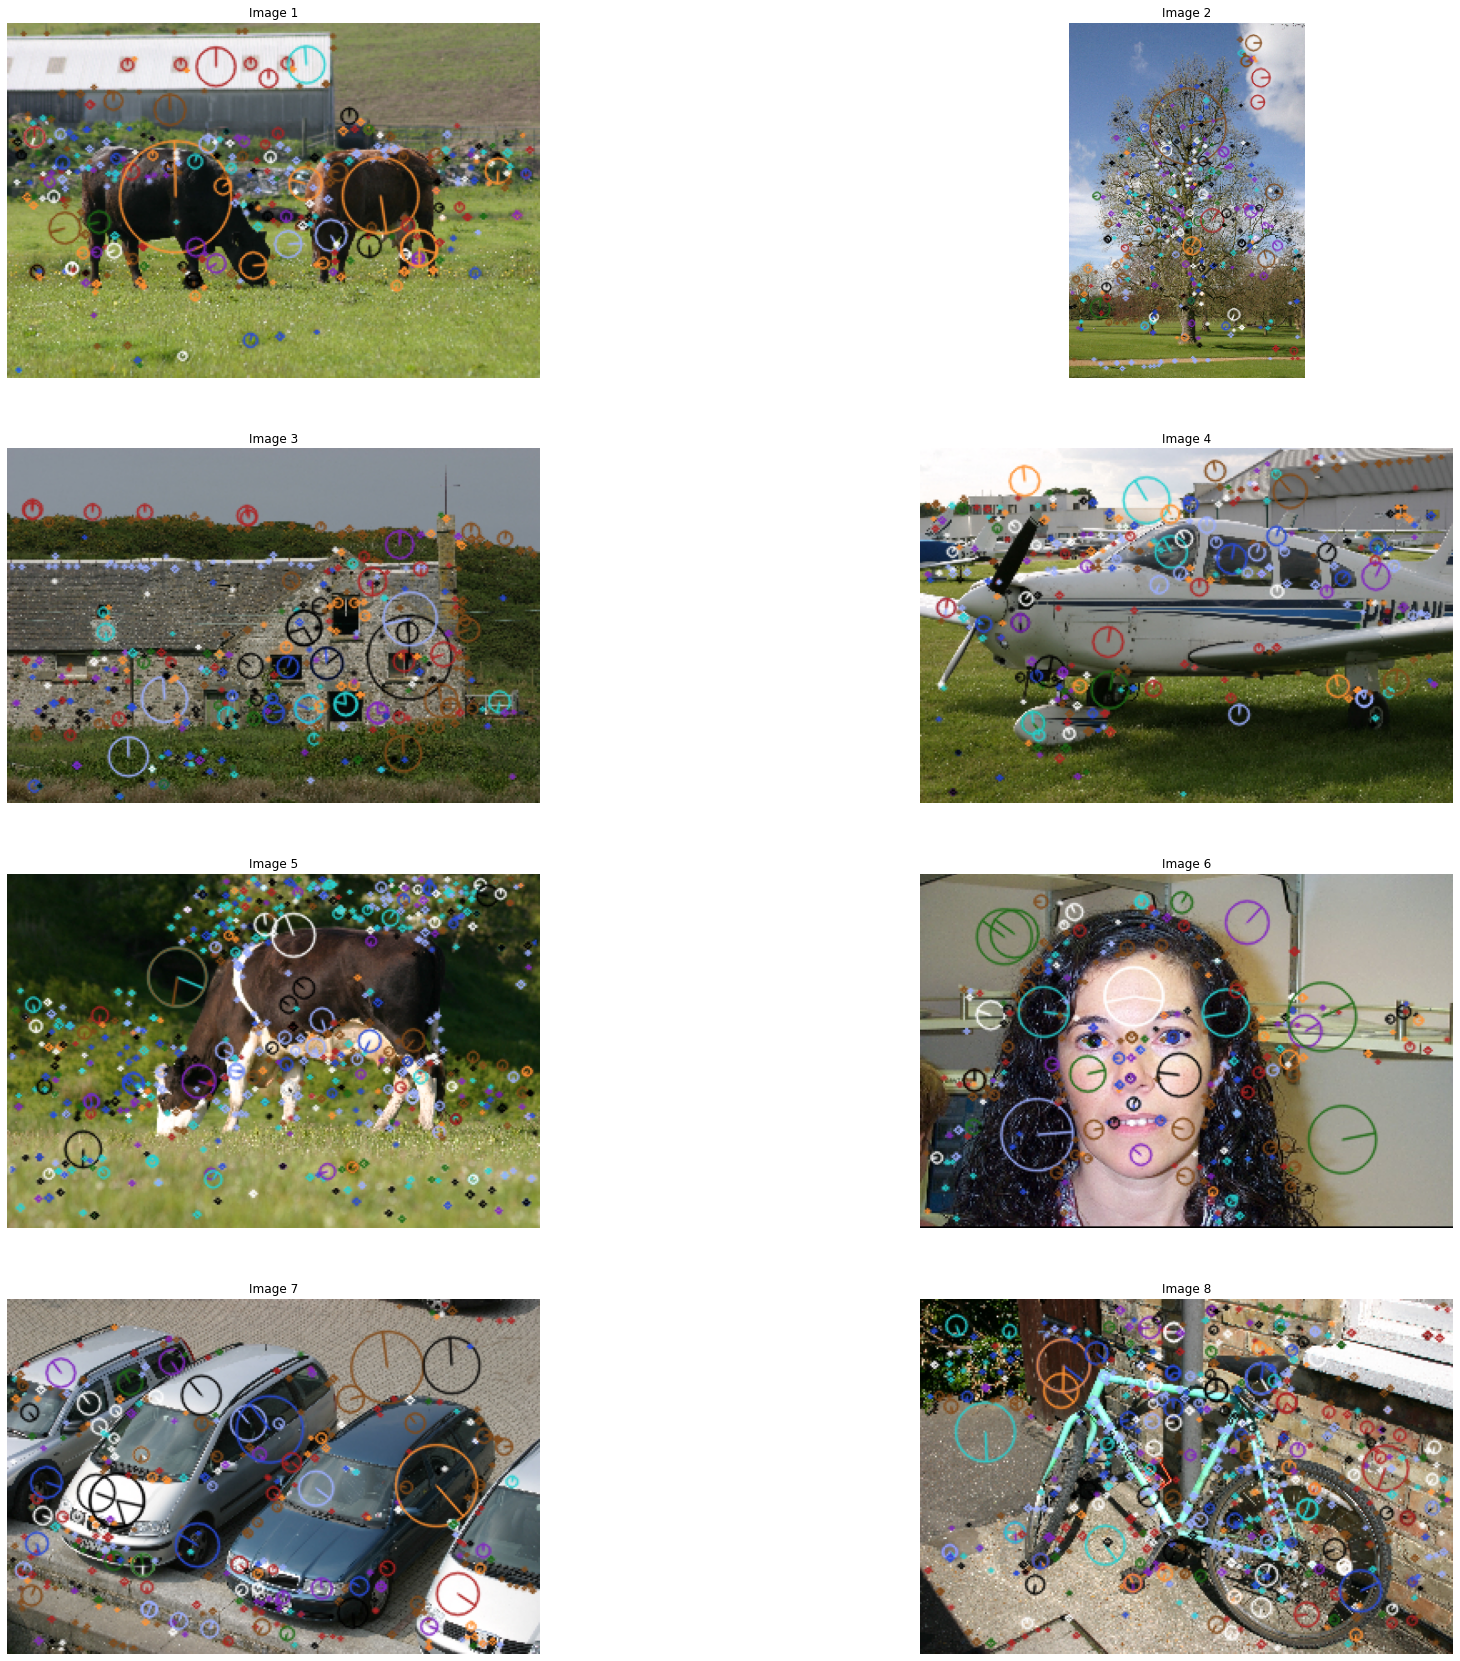

In [68]:
f, ax = plt.subplots(4, 2, figsize=(30,30))
ax[0,0].imshow(test_patches[0])
ax[0,0].axis('off')
ax[0,0].set_title('Image 1')
ax[0,1].imshow(test_patches[1])
ax[0,1].axis('off')
ax[0,1].set_title('Image 2')
ax[1,0].imshow(test_patches[2])
ax[1,0].axis('off')
ax[1,0].set_title('Image 3')
ax[1,1].imshow(test_patches[3])
ax[1,1].axis('off')
ax[1,1].set_title('Image 4')
ax[2,0].imshow(test_patches[4])
ax[2,0].axis('off')
ax[2,0].set_title('Image 5')
ax[2,1].imshow(test_patches[5])
ax[2,1].axis('off')
ax[2,1].set_title('Image 6')
ax[3,0].imshow(test_patches[6])
ax[3,0].axis('off')
ax[3,0].set_title('Image 7')
ax[3,1].imshow(test_patches[7])
ax[3,1].axis('off')
ax[3,1].set_title('Image 8')

plt.show()



## Results 
As we can see from the above images the model didn't perform too bad even though most of the image sections are confused (trying with more topics gives less understandable patches). Here are some observations:
*   The most recognizable descriptors are the brown ones: in most of the images they seem to represent some border of objects e.g. the roofs in image 1 and 4 and the hill and part of the house in image 3 or even the cars in image 7.
*   In most cases, orange descriptors are related to big darker zones of images such as the animals in image 1, the car in image 7 and a window in image 3. The animals in image 1 are well described and mostly present only this kind of patches.
*   Light blue patches seems indeed to be related with long and narrow segments of images, specially of light colors e.g. the top of the roof in image 3, the main structure of the bike in image 8, some parts of the plane in image 4.
*   Black and white visual patches are mostly common in bushes and specially in the tree in image 2 although these appear to have less clear meaning.
*   Bushes and grass seem to present lots of patches of color light blue or blue or cyan.
*   Red patches feature small or big zones of uniform light color e.g. the windows on the roof in image 1, the clouds in image 2, the sky in image 3 and some bricks in image 8.

Unfortunately it's not clear how the visual words are grouped and this might only be a poor interpretations of the topics they were assigned to.

# Gensim implementation


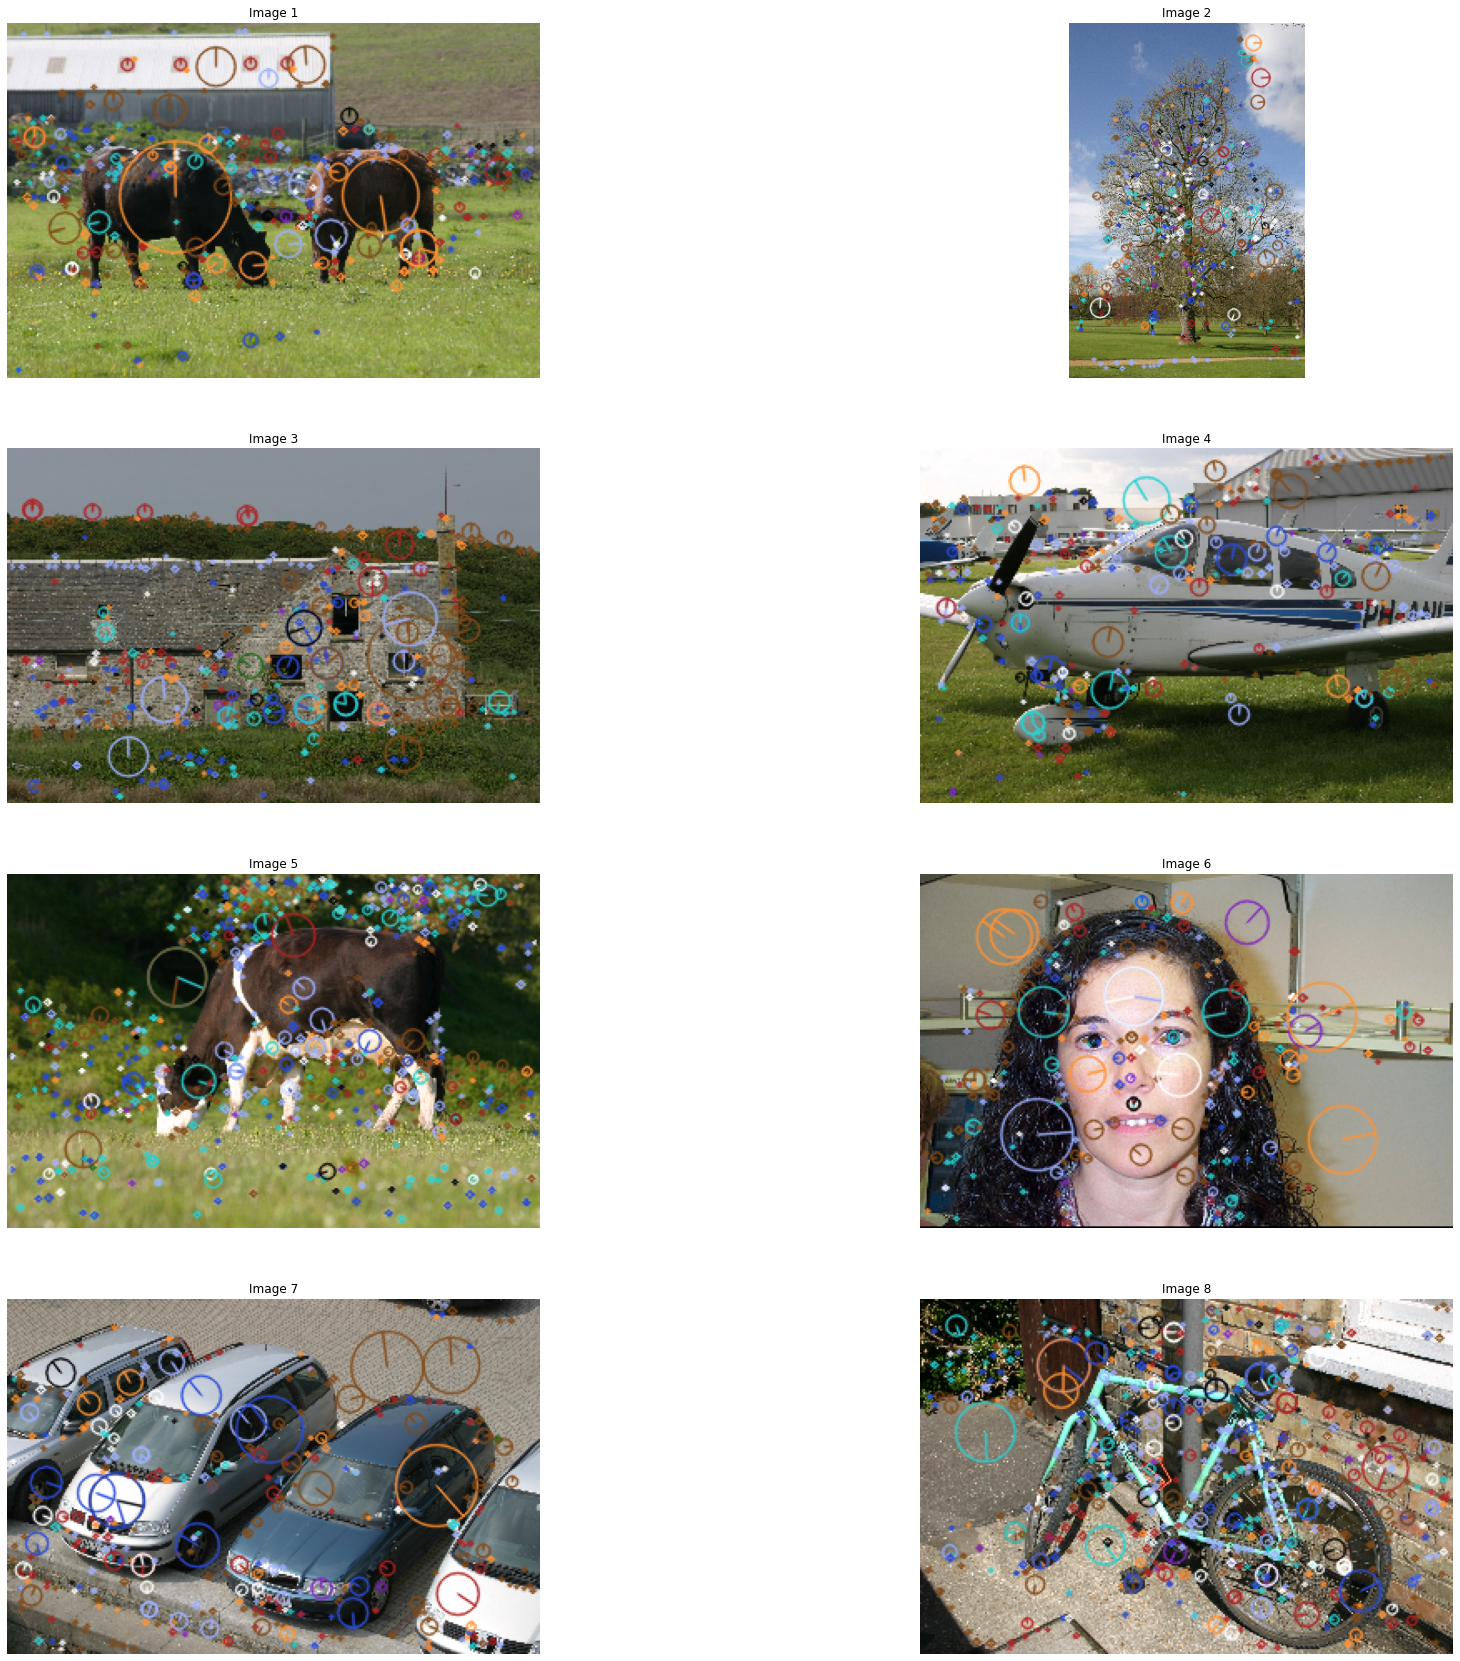

In [69]:
f, ax = plt.subplots(4, 2, figsize=(30,30))
ax[0,0].imshow(test_patches_gen[0])
ax[0,0].axis('off')
ax[0,0].set_title('Image 1')
ax[0,1].imshow(test_patches_gen[1])
ax[0,1].axis('off')
ax[0,1].set_title('Image 2')
ax[1,0].imshow(test_patches_gen[2])
ax[1,0].axis('off')
ax[1,0].set_title('Image 3')
ax[1,1].imshow(test_patches_gen[3])
ax[1,1].axis('off')
ax[1,1].set_title('Image 4')
ax[2,0].imshow(test_patches_gen[4])
ax[2,0].axis('off')
ax[2,0].set_title('Image 5')
ax[2,1].imshow(test_patches_gen[5])
ax[2,1].axis('off')
ax[2,1].set_title('Image 6')
ax[3,0].imshow(test_patches_gen[6])
ax[3,0].axis('off')
ax[3,0].set_title('Image 7')
ax[3,1].imshow(test_patches_gen[7])
ax[3,1].axis('off')
ax[3,1].set_title('Image 8')

plt.show()

## Results
Let's start analyzing the results for the lda model from the gensim package by noting that even though the two models were trained independently the colors and the topics are approximateley coherent: the two models seemed to have grouped the words in the same topics in most cases.

With the gensim model as well the topics and the colors appear to be confused with no clear interpretation in most cases:
*   As before the most recognizable descriptors are the brown ones: borders of some kind.
*   Orange descriptors seem to be related to big dark zones of images even though there is a wide presence of them in the background of image 6. The animals in image 1 are again well represented by these orange patches.
*   Light blue patches seem again to be related with long and narrow segments of images with the same examples as above.
*   Black and white visual patches are mostly common in bushes and specially in the tree in image 2 although these appear to have less clear meaning.
*   Bushes and grass feature a lot of blue and cyan patches. With this model this observation is more clear with respect to the previous model.
*   Red patches feature again small or big zones of uniform light color e.g. the windows on the roof in image 1, the clouds in image 2, the sky in image 3 and some bricks in image 8.

Even in this case these are all supposition as most of the topics have no clear interpretation or noticeable constant features.   

# Experiment: SVM classifier with BOVW
In this last section I wanted to experiment with the BOVW and a simple SVM classifier on this features.

The labels are simply the thematic subset of the image which is an integer number between 1 and 8.

The bovw matrix of shape (n_images, n_words) is the matrix of features used for training the model on the training set. To find the best parameters I used a 5-fold cross validation.

In [64]:
from sklearn.model_selection import GridSearchCV
svc = SVC()
parameters = {'C': [1,10,20,50,100,200,500,1000], 'kernel':('linear', 'rbf'), 'gamma': ('scale','auto')}
tuner = GridSearchCV(estimator=svc, param_grid=parameters, verbose=1)
tuner.fit(X=train_bovw, y=train_labels)
print(f'Best parameters are: {tuner.best_params_}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters are: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Train accuracy: 1.0
Test accuracy: 0.875


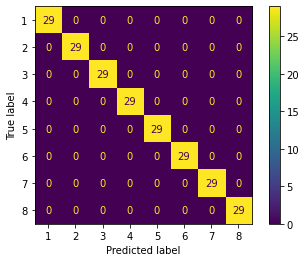

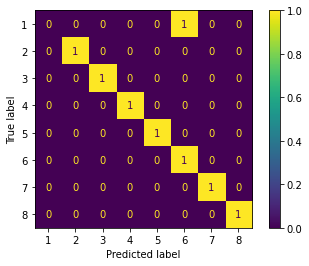

In [65]:
# Classifier
# Get best estimator
svm_bovw = tuner.best_estimator_
# Prediction
train_bovw_pred = svm_bovw.predict(X=train_bovw)
test_bovw_pred = svm_bovw.predict(X=test_bovw)
# Print Accuracies
print(f'Train accuracy: {accuracy_score(train_labels, train_bovw_pred)}')
print(f'Test accuracy: {accuracy_score(test_labels, test_bovw_pred)}')
# Generate and plot confusion matrices
train_conf = confusion_matrix(train_labels, train_bovw_pred, labels=labels)
test_conf = confusion_matrix(test_labels, test_bovw_pred, labels=labels)
disp = ConfusionMatrixDisplay(train_conf, display_labels=labels)
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(test_conf, display_labels=labels)
disp.plot()
plt.show()

As we can see results are not bad, as the accuracies on the training set is 100% while the accuracy on the test set is of 87.5% (all but one test image are predicted correctly).

# Conclusions

The LDA model for word-topic assignement was tested with the visual patches and descriptor found using the SIFT feature extractor. As widely seen from results above this topics unfortunately don't provide a clear interpretation. I also tried to lower the number of topics to have more uniformity but this didn't really give an interpretation advantage over losing topics. I also wanted to try matching the semantic ground truth classes of the dataset which were 9. Results were not so bad considering the low number of training images.


The experiment of the svm classifier with the bag of visual words features worked well, showing that this is a good approach for classification tasks although the test set is small and this model should be tested more.